## Einzelparameteranalyse für max_depth und n_estimators

Original Train Set: (15172, 22), Oversampled Train Set: (24927, 22)

=== Einfluss von max_depth ===
   max_depth   F1 Mean    F1 Std  Accuracy Mean  Train Logloss  Val Logloss  \
0          4  0.616093  0.006759       0.617402       0.789018     0.849587   
1          6  0.722441  0.005137       0.722951       0.568552     0.708473   
2          8  0.810025  0.005022       0.811168       0.336236     0.551122   
3         10  0.854089  0.004545       0.855177       0.155669     0.425341   
4         12  0.867330  0.003912       0.868175       0.064461     0.360106   
5         14  0.870251  0.003287       0.870903       0.032661     0.341696   
6         16  0.873298  0.005103       0.873872       0.020925     0.337432   
7         18  0.870570  0.003580       0.871184       0.015948     0.339903   

   Overfit Gap  
0     0.060569  
1     0.139921  
2     0.214887  
3     0.269672  
4     0.295645  
5     0.309035  
6     0.316507  
7     0.323956  


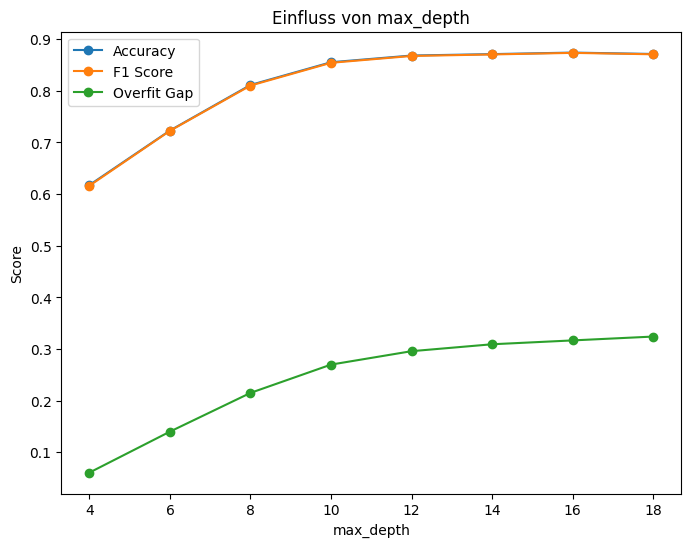


=== Einfluss von n_estimators ===
   n_estimators   F1 Mean    F1 Std  Accuracy Mean  Train Logloss  \
0           100  0.619872  0.009263       0.621414       0.794089   
1           200  0.666549  0.009235       0.667108       0.687711   
2           300  0.702699  0.006104       0.703133       0.606986   
3           500  0.748976  0.004404       0.749749       0.484156   
4           800  0.791201  0.003394       0.792434       0.356597   

   Val Logloss  Overfit Gap  
0     0.854785     0.060695  
1     0.784513     0.096802  
2     0.732660     0.125675  
3     0.654070     0.169914  
4     0.573289     0.216693  


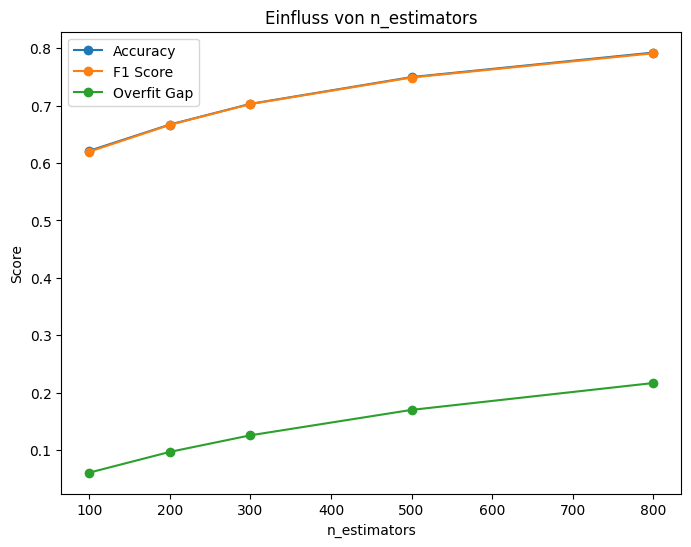

In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# === 0. Daten laden ===
df = pd.read_csv("Data/preprocessed/combined_preprocessed.csv")

# === 1. Labels von 5 → 3 Klassen mappen ===
def map_labels(x):
    if x == 0:
        return 0   # sehr schnell adoptiert
    elif x == 4:
        return 2   # gar nicht adoptiert
    else:
        return 1   # mittlere Geschwindigkeiten (1,2,3)

df['target'] = df['AdoptionSpeed'].map(map_labels)

# === 2. Features & Ziel ===
X = df.drop(columns=['AdoptionSpeed', 'target'])
y = df['target'].astype(int)

# === 3. Train/Test Split (Validierung wird später in CV abgebildet) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 4. Kategorische Variablen in Kategorie-Typ umwandeln ===
for df_ in [X_train, X_test]:
    for col in df_.select_dtypes(include=["object"]).columns:
        df_[col] = df_[col].astype("category")

# === 5. Oversampling nur auf Train ===
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(f"Original Train Set: {X_train.shape}, Oversampled Train Set: {X_train_res.shape}")

# === 6. Kategorische Spalten encodieren (OrdinalEncoder) ===
cat_cols = X_train_res.select_dtypes(include=["category"]).columns
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

if len(cat_cols) > 0:
    X_train_res[cat_cols] = oe.fit_transform(X_train_res[cat_cols])
    X_test[cat_cols]      = oe.transform(X_test[cat_cols])

# === 7. Hilfsfunktion für CV-Auswertung ===
def evaluate_param(param_name, values, fixed_params):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for val in values:
        f1_scores, acc_scores, train_lls, val_lls, gaps = [], [], [], [], []

        for train_idx, val_idx in cv.split(X_train_res, y_train_res):
            X_tr, X_val = X_train_res.iloc[train_idx], X_train_res.iloc[val_idx]
            y_tr, y_val = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

            dtrain = xgb.DMatrix(X_tr, label=y_tr)
            dval   = xgb.DMatrix(X_val, label=y_val)

            params = {
                'objective': 'multi:softprob',
                'num_class': 3,
                'eval_metric': 'mlogloss',
                'random_state': 42,
                'verbosity': 0,
                **fixed_params
            }

            evals_result = {}

            # WICHTIG: wenn n_estimators, dann num_boost_round variieren
            if param_name == "n_estimators":
                model = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=val,
                    evals=[(dtrain, "train"), (dval, "val")],
                    evals_result=evals_result,
                    verbose_eval=False
                )
            else:
                params[param_name] = val
                model = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=200,
                    evals=[(dtrain, "train"), (dval, "val")],
                    evals_result=evals_result,
                    verbose_eval=False
                )

            # Vorhersagen & Scores
            preds = np.argmax(model.predict(dval), axis=1)
            f1_scores.append(f1_score(y_val, preds, average="macro"))
            acc_scores.append(accuracy_score(y_val, preds))

            train_ll = evals_result["train"]["mlogloss"][-1]
            val_ll   = evals_result["val"]["mlogloss"][-1]
            train_lls.append(train_ll)
            val_lls.append(val_ll)
            gaps.append(val_ll - train_ll)

        results.append({
            param_name: val,
            "F1 Mean": np.mean(f1_scores),
            "F1 Std": np.std(f1_scores),
            "Accuracy Mean": np.mean(acc_scores),
            "Train Logloss": np.mean(train_lls),
            "Val Logloss": np.mean(val_lls),
            "Overfit Gap": np.mean(gaps)
        })

    return pd.DataFrame(results)

# === 8. Analyse max_depth ===
depths = list(range(4, 19, 2))  # 2 bis 18
df_depth = evaluate_param("max_depth", depths, fixed_params={
    "learning_rate": 0.1,
    "n_estimators": 300
})
print("\n=== Einfluss von max_depth ===")
print(df_depth)

plt.figure(figsize=(8,6))
plt.plot(df_depth["max_depth"], df_depth["Accuracy Mean"], marker="o", label="Accuracy")
plt.plot(df_depth["max_depth"], df_depth["F1 Mean"], marker="o", label="F1 Score")
plt.plot(df_depth["max_depth"], df_depth["Overfit Gap"], marker="o", label="Overfit Gap")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.title("Einfluss von max_depth")
plt.legend()
plt.show()

# === 9. Analyse n_estimators ===
estimators = [100, 200, 300, 500, 800]
df_estimators = evaluate_param("n_estimators", estimators, fixed_params={
    "learning_rate": 0.1,
    "max_depth": 5
})
print("\n=== Einfluss von n_estimators ===")
print(df_estimators)

plt.figure(figsize=(8,6))
plt.plot(df_estimators["n_estimators"], df_estimators["Accuracy Mean"], marker="o", label="Accuracy")
plt.plot(df_estimators["n_estimators"], df_estimators["F1 Mean"], marker="o", label="F1 Score")
plt.plot(df_estimators["n_estimators"], df_estimators["Overfit Gap"], marker="o", label="Overfit Gap")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Einfluss von n_estimators")
plt.legend()
plt.show()
